In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from tensorflow import keras
from tensorflow.keras import callbacks
from uproot_io import Events, View
from tensorflow.keras.models import load_model

# Extracting the data
We need event images and their labels.

In [5]:
# Creating Event objects for the data
events1 = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")
events2 = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_2.root")
events3 = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_3.root")
events4 = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_4.root")

In [6]:
# Getting the event indices and finding the number of events in each file
numbers1 = np.array(list(set(events1.event_number)))
numbers2 = np.array(list(set(events2.event_number)))
numbers3 = np.array(list(set(events3.event_number)))
numbers4 = np.array(list(set(events4.event_number)))
len(numbers1), len(numbers2), len(numbers3), len(numbers4)

(9310, 9265, 9310, 9257)

In [7]:
# Creating view classes for each event
view_w1 = View(events1, "w")
view_w2 = View(events2, "w")
view_w3 = View(events3, "w")
view_w4 = View(events4, "w")

In [ ]:
# Plotting function for each view
def plot_w_event(view_w, number):
    x = view_w.x[number]
    z = view_w.z[number]
    adc = view_w.adc[number]
    vx = view_w.true_vtx_x[number]
    vz = view_w.true_vtx_z[number]
    
    plt.scatter(x, z, c=adc, s=0.5)
    plt.scatter(vx, vz, c='red', s=50)
    cbar = plt.colorbar()
    cbar.set_label('ADC')
    plt.xlabel('Time')
    plt.ylabel('W Wire')
    plt.show()

In [8]:
# Functions to extract the truth record for each event

def labelling(numbers, events):
    '''Labels muon neutrino events as: 0
       Labels electron neutrino events as: 1
       Labels neutral current events as: 2'''
    label = []
    
    for n in numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])

        if 13 in mcp or -13 in mcp:
            label.append(0)

        elif 11 in mcp or -11 in mcp:
            label.append(1)    
            
        else:
            label.append(2)
            
    return np.array(label)

def process_numbers(numbers, events):
    '''Labels muon neutrino events as: [1,0,0]
       Labels electron neutrino events as: [0,1,0]
       Labels neutral current events as: [0,0,1]'''
    labels = []
    for n in numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])

        if 11 in mcp or -11 in mcp:
            labels.append([0, 1, 0])
        elif 13 in mcp or -13 in mcp:
            labels.append([1, 0, 0])
        else:
            labels.append([0, 0, 1])
    return labels

def oneHotLabelling(numbers_list, events_list):
    labels = []
    for numbers, events in zip(numbers_list, events_list):
        labels.extend(process_numbers(numbers, events))
    return np.array(labels).astype(float)

In [11]:
labels1 = oneHotLabelling([numbers1], [events1])

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [12]:
np.save('labels1', labels1)

In [51]:
# Making the event images suitable for a CNN

def image(numbers_list, views_list):
    """Creates 128 by 128 pixels images for each event, making sure the interaction vertex is included."""
    images = []
    
    for numbers, view_w in zip(numbers_list, views_list):
        for n in numbers:
            x, z, adc, vx, vz = view_w.x[n], view_w.z[n], view_w.adc[n], view_w.true_vtx_x[n], view_w.true_vtx_z[n]
            
            x_mean, z_mean = np.floor(np.mean(x)), np.floor(np.mean(z))
            minusx, plusx = x_mean - 100, x_mean + 100
            minusz, plusz = z_mean - 100, z_mean + 100
            
            if vx < minusx:
                minusx = np.floor(vx)-20
                plusx = np.floor(vx)+180
            if vx > plusx:
                minusx = np.floor(vx)-180
                plusx = np.floor(vx)+20
            if vz < minusz:
                minusz = np.floor(vz)-20
                plusz = np.floor(vz)+180
            if vz > plusz:
                minusz = np.floor(vz)-180
                plusz = np.floor(vz)+20

            matrix, _, _ = np.histogram2d(x, z, bins=256, range=[[minusx, plusx], [minusz, plusz]], weights=adc)
            matrix = (matrix > 0).astype(np.uint8).reshape(256, 256, 1)
            images.append(matrix)

    return np.stack(images)

In [52]:
images1 = image([numbers1], [view_w1])

In [53]:
np.save('images1', images1)

In [54]:
all_images_squeezed = np.squeeze(all_images)

# Check for all-zero matrices in a vectorized manner
is_all_zero = np.all(all_images_squeezed == 0, axis=(1, 2))

# Indices of all-zero matrices
all_zeros_indices = np.where(is_all_zero)[0]

# Use this mask to select only the images that are not completely zeros
keep_images_mask = ~is_all_zero

# Apply this mask to filter out the all-zero images
filtered_images = all_images[keep_images_mask]

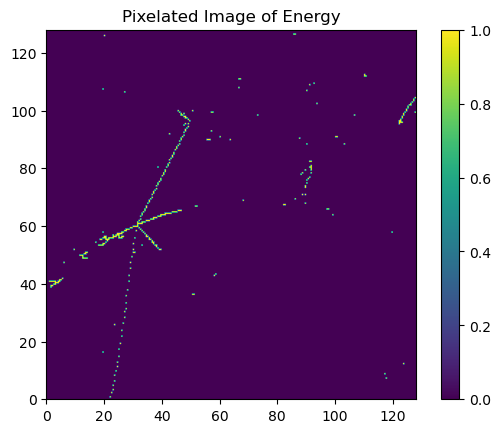

In [58]:
# Display the image
image_to_display = images1[2343].reshape(256,256)

plt.imshow(image_to_display, cmap='viridis', origin='lower', extent=[0, 128, 0, 128])
plt.colorbar()
plt.title('Pixelated Image of Energy')
plt.show()

In [59]:
# Generate random indices
random_numbers = np.random.permutation(len(labels1))

# Calculate the indices for each subset
seventy_percent = int(0.7 * len(random_numbers))
five_percent = int(0.05 * len(random_numbers))

# Split the indices into training, validation, and testing
training_indices = random_numbers[:seventy_percent]
validation_indices = random_numbers[seventy_percent:seventy_percent + five_percent]
testing_indices = random_numbers[seventy_percent + five_percent:]

In [60]:
# Splitting the data
x_train1 = images1[training_indices]
y_train1 = labels1[training_indices]

x_val1 = images1[validation_indices]
y_val1 = labels1[validation_indices]

x_test1 = images1[testing_indices]
y_test1 = labels1[testing_indices]

In [61]:
np.save('x_train1', x_train1)
np.save('y_train1', y_train1)

np.save('x_val1', x_val1)
np.save('y_val1', y_val1)

np.save('x_test1', x_test1)
np.save('y_test1', y_test1)

In [62]:
len(x_train1), len(x_val1), len(x_test1)

(6517, 465, 2328)

In [77]:
# model 2

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = 3

# Input layer
input_layer = keras.layers.Input(x_train1[0].shape)
# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.5)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.5)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.5)(x)

# Flatten the output of the conv layers
x = Flatten()(x)

# Dense layer
x = Dense(128, activation='relu')(x)

x = Dropout(0.25)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)  # 3 classes for the output

# Creating the model
model = keras.Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 128)       7385

In [78]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 15
# The learning rate (step size in gradient descent)
learning_rate = 0.001

In [79]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [80]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
history = model.fit(x = x_train1, y = y_train1, batch_size = batch_size, epochs = epochs,
                  validation_data = (x_val1, y_val1), verbose = 1)

Epoch 1/15
51/51 [==============================] - 153s 3s/step - loss: 1.1060 - accuracy: 0.4232 - val_loss: 0.9083 - val_accuracy: 0.5419
Epoch 2/15
51/51 [==============================] - 172s 3s/step - loss: 0.7852 - accuracy: 0.6603 - val_loss: 0.8270 - val_accuracy: 0.6731
Epoch 3/15
51/51 [==============================] - 341s 7s/step - loss: 0.7302 - accuracy: 0.7045 - val_loss: 0.7612 - val_accuracy: 0.6925
Epoch 4/15
51/51 [==============================] - 170s 3s/step - loss: 0.7126 - accuracy: 0.7201 - val_loss: 0.7899 - val_accuracy: 0.6968
Epoch 5/15
51/51 [==============================] - 172s 3s/step - loss: 0.6901 - accuracy: 0.7511 - val_loss: 1.1177 - val_accuracy: 0.6366
Epoch 6/15
 7/51 [===>..........................] - ETA: 2:21 - loss: 0.6396 - accuracy: 0.7667

KeyboardInterrupt: 

In [74]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test1.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = model.predict(x = x_test1[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

19/19 [==============================] - 8s 432ms/step
Number of images that were incorrectly classified = 1443


In [75]:
loss, accuracy = model.evaluate(x_test1, y_test1)

73/73 [==============================] - 6s 79ms/step - loss: 5.5335 - accuracy: 0.5284
